In [19]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
import sklearn
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
#from tqdm import tqdm_notebook,trange
print("done import")

done import


In [3]:
path = '/Users/yehonatanperetz/histopathologic-cancer-detection/'
train_path = '/Users/yehonatanperetz/histopathologic-cancer-detection/train/'
test_path = '/Users/yehonatanperetz/histopathologic-cancer-detection/test/'

In [4]:
all_train_df = pd.read_csv(path+"train_labels.csv")
all_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
print("Train Size: {}".format(len(os.listdir(train_path))))
print("Test Size: {}".format(len(os.listdir(test_path))))

Train Size: 220027
Test Size: 57458


In [6]:
label_counts = all_train_df.label.value_counts()
print(label_counts)



label
0    130908
1     89117
Name: count, dtype: int64


In [7]:
# Number of samples in each class
SAMPLE_SIZE = 1000


# Use 80000 positive and negative examples
df_label0 = all_train_df[all_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_label1 = all_train_df[all_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_label0, df_label1], axis=0).reset_index(drop=True))

train_df.shape

(2000, 2)

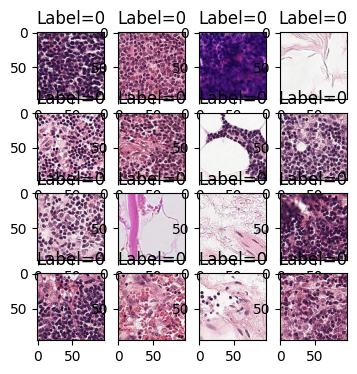

In [8]:
#print(train_df.head(2))
#print(train_imgs[1])
N_plot=4
fig = plt.figure(figsize=(N_plot, N_plot)) 

for i in range(1,N_plot**2+1):
        img=Image.open(train_path+train_df['id'][i]+'.tif')
        fig.add_subplot(N_plot, N_plot, i)
        plt.imshow(img)
        plt.title('Label=%s'%train_df['label'][i])
    

        



In [9]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df['label'][0:N])
    for i in range(0,N):
        img=Image.open(train_path+df['id'][i]+'.tif')
        img_rgb = img.convert('RGB')
        X[i] = np.array(img_rgb)
    return X,y

In [10]:

img=Image.open(train_path+'lines_proto.tiff')
img_rgb = img.convert('RGB')
x0 = np.array(img_rgb)

img=Image.open(train_path+'x_proto.tiff')
img_rgb = img.convert('RGB')
x1 = np.array(img_rgb)

def generate_data(N):
# Loading N images from df dataframe
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.zeros([N,1],dtype=np.uint8);
    for i in range(0,N):
        if i%2==0:
            X[i] = x0+np.random.normal(0,2/2,(96,96,3))
            y[i]=np.int32(0)
        else:
            X[i] = x1+np.random.normal(0,60/2,(96,96,3))
            y[i]=np.int32(1)

    return X,y

In [11]:
load_fake_data=False
if load_fake_data==False: 
    X,y = load_data(N=2*SAMPLE_SIZE,df=train_df)
    y=np.reshape(y,[len(y),1])
    print(X.shape)
    print(y.shape)

(2000, 96, 96, 3)
(2000, 1)


In [12]:
if load_fake_data==True: 
    X,y = generate_data(N=2*SAMPLE_SIZE) 
    print(X.shape)
    print(y.shape)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

[0]


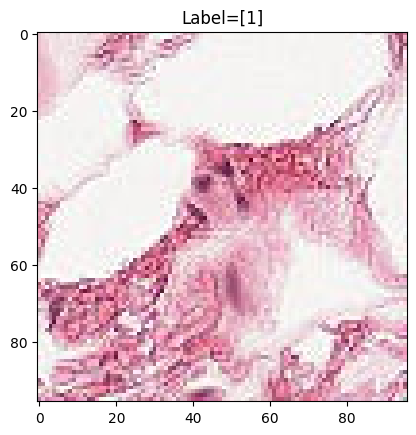

In [14]:
k=14
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()

[1]


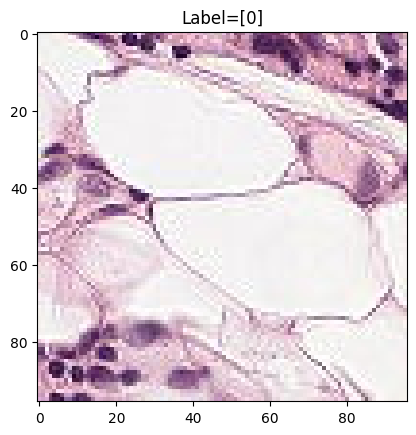

In [15]:
k=15
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()

In [16]:
#create random batches for training

N_train=len(X_train)
batch_size=50;
N_batches=np.int32(np.floor(N_train/batch_size))
def random_batch(n, k, tot):
    start_points = np.sort(np.random.randint(0, tot-k, size=n))
    end_points = start_points + k
    end_points[:-1] = np.maximum(end_points[:-1], start_points[1:])
    return list(zip(np.int32(start_points), np.int32(end_points)))


batches=random_batch(N_batches,batch_size,N_train)
#print(len(batches))
#print(batches)


In [54]:
from keras.layers import * 
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Input(shape=(96, 96, 3)))
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2))) 
#model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(128, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2))) 
#model.add(Dropout(0.5))

model.add(Conv2D(256, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(256, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(256, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2))) 
#model.add(Dropout(0.5))


model.add(Conv2D(512, (3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(512, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(512, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2))) 





model.add(Dense(4096, use_bias=True))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(4096, use_bias=True))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1000, use_bias=True))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dense(1, activation = "sigmoid"))


In [55]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_155 (Conv2D)             │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 94, 94, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 92, 92, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 92, 92, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 92, 92, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 44, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 42, 42, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 19, 19, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 17, 17, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 17, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 15, 15, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 15, 15, 256)    │         1,02

 Total params: 30,661,617 (116.96 MB)

 Trainable params: 30,637,857 (116.87 MB)

 Non-trainable params: 23,760 (92.81 KB)

In [56]:

sgd = keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=sgd, 
              metrics=['accuracy'])



In [57]:
N_epochs=3;


for epoch in range(1,N_epochs+1):
    model.fit(X_train,y_train, validation_data=(X_val,y_val))

ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node sequential_15_1/max_pooling2d_52_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](sequential_15_1/activation_35_1/Relu)' with input shapes: [?,1,1,512].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(None, 1, 1, 512), dtype=float32)

In [39]:
N_epochs=3;


for epoch in range(1,N_epochs+1):
    for i in range (0,N_batches-1):
        batch_start=batches[i][0]
        batch_end=batches[i][1]
        loss, acc = model.train_on_batch(X_train[batch_start:batch_end],y_train[batch_start:batch_end])
        print('Training Epoch #'+str(np.round(epoch,0))+': loss='+str(np.round(loss,2))+' accuracy='+str(np.round(acc,2))+' Progress=',str(np.round(i*100/N_batches))+'%',end='\r')
    print('Training Epoch #'+str(np.round(epoch,0))+': loss='+str(np.round(loss,2))+' accuracy='+str(np.round(acc,2)))  

model.save(path+'/model1.keras') 



ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node sequential_6_1/max_pooling2d_11_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](sequential_6_1/conv2d_38_1/Relu)' with input shapes: [52,1,1,128].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(52, 1, 1, 128), dtype=float32)